# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.09KFile/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

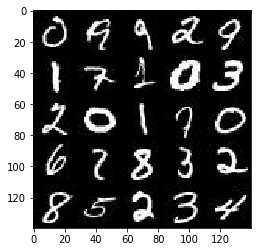

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

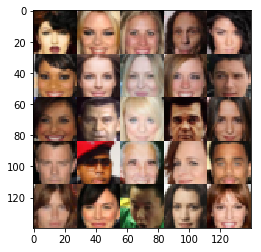

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, 
                                                    image_height, 
                                                    image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,
                                   name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [57]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        relu1 = tf.layers.dropout(relu1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        relu2 = tf.layers.dropout(relu2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        relu3 = tf.layers.dropout(relu3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits)
        out = tf.sigmoid(logits)
    
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [58]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*2048)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 2048))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 1024, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x256 now
        
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
#         logits = tf.layers.dense(logits, 28 * 28 * out_channel_dim)
#         logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        # 16x16x128 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [59]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real) * np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [60]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [62]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]


    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, output_dim)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1

                #Rescaling images
                batch_images *= 2.0

                # Random Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimizing
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)

    return None

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [63]:
# batch_size = None
# z_dim = None
# learning_rate = None
# beta1 = None


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# epochs = 2

# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
# with tf.Graph().as_default():
#     train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
#           mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 3.7847... Generator Loss: 0.1262
Epoch 1/1 Batch# 20... Discriminator Loss: 2.4158... Generator Loss: 1.3720
Epoch 1/1 Batch# 30... Discriminator Loss: 1.1606... Generator Loss: 2.6682
Epoch 1/1 Batch# 40... Discriminator Loss: 2.4281... Generator Loss: 2.7884
Epoch 1/1 Batch# 50... Discriminator Loss: 2.8264... Generator Loss: 0.1877
Epoch 1/1 Batch# 60... Discriminator Loss: 2.4999... Generator Loss: 0.2981
Epoch 1/1 Batch# 70... Discriminator Loss: 2.3344... Generator Loss: 0.3215
Epoch 1/1 Batch# 80... Discriminator Loss: 2.1404... Generator Loss: 0.3822
Epoch 1/1 Batch# 90... Discriminator Loss: 1.9027... Generator Loss: 0.5464
Epoch 1/1 Batch# 100... Discriminator Loss: 1.9396... Generator Loss: 0.5326


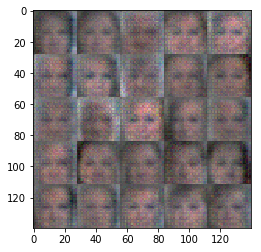

Epoch 1/1 Batch# 110... Discriminator Loss: 1.7604... Generator Loss: 0.5133
Epoch 1/1 Batch# 120... Discriminator Loss: 1.7307... Generator Loss: 0.5841
Epoch 1/1 Batch# 130... Discriminator Loss: 1.6879... Generator Loss: 0.5555
Epoch 1/1 Batch# 140... Discriminator Loss: 2.0223... Generator Loss: 0.4201
Epoch 1/1 Batch# 150... Discriminator Loss: 1.6174... Generator Loss: 0.5812
Epoch 1/1 Batch# 160... Discriminator Loss: 1.6812... Generator Loss: 0.5741
Epoch 1/1 Batch# 170... Discriminator Loss: 1.4909... Generator Loss: 0.9695
Epoch 1/1 Batch# 180... Discriminator Loss: 1.4755... Generator Loss: 0.8503
Epoch 1/1 Batch# 190... Discriminator Loss: 1.4452... Generator Loss: 0.9675
Epoch 1/1 Batch# 200... Discriminator Loss: 1.4770... Generator Loss: 0.8853


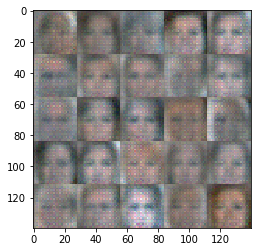

Epoch 1/1 Batch# 210... Discriminator Loss: 1.9533... Generator Loss: 0.3984
Epoch 1/1 Batch# 220... Discriminator Loss: 1.4083... Generator Loss: 0.9202
Epoch 1/1 Batch# 230... Discriminator Loss: 1.1964... Generator Loss: 1.4882
Epoch 1/1 Batch# 240... Discriminator Loss: 1.3592... Generator Loss: 1.3091
Epoch 1/1 Batch# 250... Discriminator Loss: 1.6151... Generator Loss: 0.5530
Epoch 1/1 Batch# 260... Discriminator Loss: 1.4229... Generator Loss: 0.8514
Epoch 1/1 Batch# 270... Discriminator Loss: 1.8863... Generator Loss: 0.3591
Epoch 1/1 Batch# 280... Discriminator Loss: 1.2710... Generator Loss: 0.9988
Epoch 1/1 Batch# 290... Discriminator Loss: 1.4780... Generator Loss: 0.7053
Epoch 1/1 Batch# 300... Discriminator Loss: 1.3482... Generator Loss: 1.5516


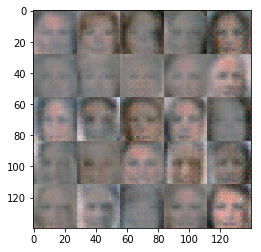

Epoch 1/1 Batch# 310... Discriminator Loss: 1.4755... Generator Loss: 0.6437
Epoch 1/1 Batch# 320... Discriminator Loss: 1.5876... Generator Loss: 0.5257
Epoch 1/1 Batch# 330... Discriminator Loss: 1.2798... Generator Loss: 0.8594
Epoch 1/1 Batch# 340... Discriminator Loss: 1.3157... Generator Loss: 1.1669
Epoch 1/1 Batch# 350... Discriminator Loss: 1.3854... Generator Loss: 2.4900
Epoch 1/1 Batch# 360... Discriminator Loss: 1.2552... Generator Loss: 0.9207
Epoch 1/1 Batch# 370... Discriminator Loss: 1.2250... Generator Loss: 1.2423
Epoch 1/1 Batch# 380... Discriminator Loss: 1.5983... Generator Loss: 0.4661
Epoch 1/1 Batch# 390... Discriminator Loss: 1.1703... Generator Loss: 0.8907
Epoch 1/1 Batch# 400... Discriminator Loss: 1.6779... Generator Loss: 0.3810


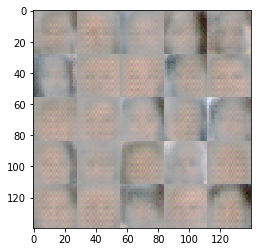

Epoch 1/1 Batch# 410... Discriminator Loss: 1.7641... Generator Loss: 0.5051
Epoch 1/1 Batch# 420... Discriminator Loss: 1.2129... Generator Loss: 1.3371
Epoch 1/1 Batch# 430... Discriminator Loss: 1.1302... Generator Loss: 2.1300
Epoch 1/1 Batch# 440... Discriminator Loss: 1.4921... Generator Loss: 1.9364
Epoch 1/1 Batch# 450... Discriminator Loss: 1.8114... Generator Loss: 0.3299
Epoch 1/1 Batch# 460... Discriminator Loss: 1.7061... Generator Loss: 0.4166
Epoch 1/1 Batch# 470... Discriminator Loss: 1.1336... Generator Loss: 1.3632
Epoch 1/1 Batch# 480... Discriminator Loss: 1.3427... Generator Loss: 0.6440
Epoch 1/1 Batch# 490... Discriminator Loss: 1.1736... Generator Loss: 0.8982
Epoch 1/1 Batch# 500... Discriminator Loss: 1.2518... Generator Loss: 2.4992


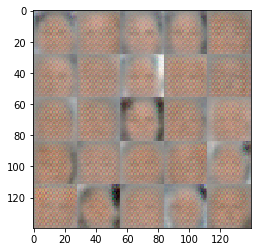

Epoch 1/1 Batch# 510... Discriminator Loss: 1.3604... Generator Loss: 0.6108
Epoch 1/1 Batch# 520... Discriminator Loss: 1.0898... Generator Loss: 1.4608
Epoch 1/1 Batch# 530... Discriminator Loss: 1.2051... Generator Loss: 1.2680
Epoch 1/1 Batch# 540... Discriminator Loss: 1.2530... Generator Loss: 0.9942
Epoch 1/1 Batch# 550... Discriminator Loss: 1.4866... Generator Loss: 1.4548
Epoch 1/1 Batch# 560... Discriminator Loss: 1.0039... Generator Loss: 1.3934
Epoch 1/1 Batch# 570... Discriminator Loss: 1.3527... Generator Loss: 0.6390
Epoch 1/1 Batch# 580... Discriminator Loss: 1.8161... Generator Loss: 0.3441
Epoch 1/1 Batch# 590... Discriminator Loss: 1.1304... Generator Loss: 0.8629
Epoch 1/1 Batch# 600... Discriminator Loss: 1.2989... Generator Loss: 0.7933


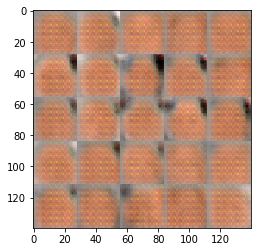

Epoch 1/1 Batch# 610... Discriminator Loss: 1.0507... Generator Loss: 1.3238
Epoch 1/1 Batch# 620... Discriminator Loss: 1.8097... Generator Loss: 1.9245
Epoch 1/1 Batch# 630... Discriminator Loss: 1.3802... Generator Loss: 1.5318
Epoch 1/1 Batch# 640... Discriminator Loss: 0.9694... Generator Loss: 1.7213
Epoch 1/1 Batch# 650... Discriminator Loss: 1.2641... Generator Loss: 0.9481
Epoch 1/1 Batch# 660... Discriminator Loss: 1.7705... Generator Loss: 1.3735
Epoch 1/1 Batch# 670... Discriminator Loss: 1.2254... Generator Loss: 1.1195
Epoch 1/1 Batch# 680... Discriminator Loss: 1.1734... Generator Loss: 1.0342
Epoch 1/1 Batch# 690... Discriminator Loss: 0.9879... Generator Loss: 1.8922
Epoch 1/1 Batch# 700... Discriminator Loss: 1.2336... Generator Loss: 0.6736


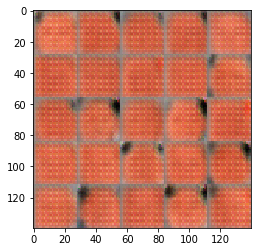

Epoch 1/1 Batch# 710... Discriminator Loss: 1.2590... Generator Loss: 1.4672
Epoch 1/1 Batch# 720... Discriminator Loss: 1.2314... Generator Loss: 1.4986
Epoch 1/1 Batch# 730... Discriminator Loss: 1.4274... Generator Loss: 0.5755
Epoch 1/1 Batch# 740... Discriminator Loss: 1.2008... Generator Loss: 0.8731
Epoch 1/1 Batch# 750... Discriminator Loss: 1.1625... Generator Loss: 0.9122
Epoch 1/1 Batch# 760... Discriminator Loss: 1.4692... Generator Loss: 1.7421
Epoch 1/1 Batch# 770... Discriminator Loss: 1.4543... Generator Loss: 2.3887
Epoch 1/1 Batch# 780... Discriminator Loss: 1.1111... Generator Loss: 2.1102
Epoch 1/1 Batch# 790... Discriminator Loss: 1.3169... Generator Loss: 0.7036
Epoch 1/1 Batch# 800... Discriminator Loss: 1.2565... Generator Loss: 1.0798


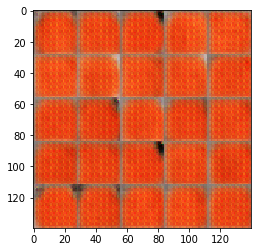

Epoch 1/1 Batch# 810... Discriminator Loss: 1.3817... Generator Loss: 0.5951
Epoch 1/1 Batch# 820... Discriminator Loss: 1.2274... Generator Loss: 3.2157
Epoch 1/1 Batch# 830... Discriminator Loss: 0.9394... Generator Loss: 1.5015
Epoch 1/1 Batch# 840... Discriminator Loss: 1.2152... Generator Loss: 0.8458
Epoch 1/1 Batch# 850... Discriminator Loss: 0.9386... Generator Loss: 1.4134
Epoch 1/1 Batch# 860... Discriminator Loss: 1.5457... Generator Loss: 0.8306
Epoch 1/1 Batch# 870... Discriminator Loss: 1.1778... Generator Loss: 0.7926
Epoch 1/1 Batch# 880... Discriminator Loss: 1.5801... Generator Loss: 3.4882
Epoch 1/1 Batch# 890... Discriminator Loss: 1.8031... Generator Loss: 0.3319
Epoch 1/1 Batch# 900... Discriminator Loss: 0.8877... Generator Loss: 2.0213


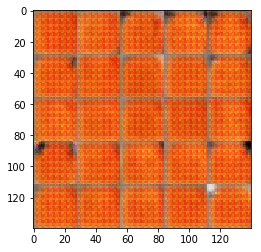

Epoch 1/1 Batch# 910... Discriminator Loss: 1.1238... Generator Loss: 0.8478
Epoch 1/1 Batch# 920... Discriminator Loss: 1.3879... Generator Loss: 0.6576
Epoch 1/1 Batch# 930... Discriminator Loss: 1.0097... Generator Loss: 1.2440
Epoch 1/1 Batch# 940... Discriminator Loss: 1.0041... Generator Loss: 1.0468
Epoch 1/1 Batch# 950... Discriminator Loss: 1.2599... Generator Loss: 0.8625
Epoch 1/1 Batch# 960... Discriminator Loss: 0.9729... Generator Loss: 1.1083
Epoch 1/1 Batch# 970... Discriminator Loss: 1.4115... Generator Loss: 0.7590
Epoch 1/1 Batch# 980... Discriminator Loss: 0.8578... Generator Loss: 1.6347
Epoch 1/1 Batch# 990... Discriminator Loss: 0.9561... Generator Loss: 1.2194
Epoch 1/1 Batch# 1000... Discriminator Loss: 1.8821... Generator Loss: 0.3248


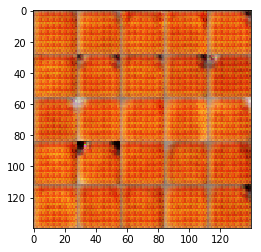

Epoch 1/1 Batch# 1010... Discriminator Loss: 1.1719... Generator Loss: 1.0261
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.2523... Generator Loss: 2.5385
Epoch 1/1 Batch# 1030... Discriminator Loss: 1.2730... Generator Loss: 1.6705
Epoch 1/1 Batch# 1040... Discriminator Loss: 1.5355... Generator Loss: 3.1081
Epoch 1/1 Batch# 1050... Discriminator Loss: 1.1049... Generator Loss: 1.3384
Epoch 1/1 Batch# 1060... Discriminator Loss: 0.7329... Generator Loss: 1.8368
Epoch 1/1 Batch# 1070... Discriminator Loss: 0.9440... Generator Loss: 1.4569
Epoch 1/1 Batch# 1080... Discriminator Loss: 1.6276... Generator Loss: 0.4097
Epoch 1/1 Batch# 1090... Discriminator Loss: 0.7972... Generator Loss: 1.7260
Epoch 1/1 Batch# 1100... Discriminator Loss: 1.2057... Generator Loss: 0.7703


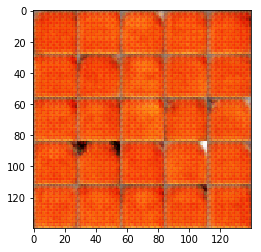

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.5120... Generator Loss: 2.4107
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.6852... Generator Loss: 0.3772
Epoch 1/1 Batch# 1130... Discriminator Loss: 0.9341... Generator Loss: 1.1449
Epoch 1/1 Batch# 1140... Discriminator Loss: 0.8391... Generator Loss: 1.4617
Epoch 1/1 Batch# 1150... Discriminator Loss: 0.6274... Generator Loss: 2.1670
Epoch 1/1 Batch# 1160... Discriminator Loss: 1.3939... Generator Loss: 1.7403
Epoch 1/1 Batch# 1170... Discriminator Loss: 1.0230... Generator Loss: 2.4272
Epoch 1/1 Batch# 1180... Discriminator Loss: 0.9684... Generator Loss: 3.1304
Epoch 1/1 Batch# 1190... Discriminator Loss: 0.6246... Generator Loss: 3.9880
Epoch 1/1 Batch# 1200... Discriminator Loss: 0.6518... Generator Loss: 2.4519


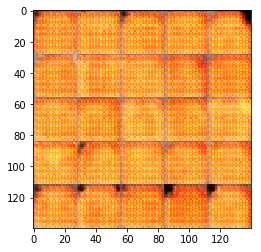

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.2073... Generator Loss: 0.7340
Epoch 1/1 Batch# 1220... Discriminator Loss: 0.8251... Generator Loss: 1.5107
Epoch 1/1 Batch# 1230... Discriminator Loss: 0.7188... Generator Loss: 1.6457
Epoch 1/1 Batch# 1240... Discriminator Loss: 1.8870... Generator Loss: 0.2875
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.0686... Generator Loss: 1.5761
Epoch 1/1 Batch# 1260... Discriminator Loss: 2.3445... Generator Loss: 0.1725
Epoch 1/1 Batch# 1270... Discriminator Loss: 1.0462... Generator Loss: 1.0371
Epoch 1/1 Batch# 1280... Discriminator Loss: 0.7111... Generator Loss: 1.7165
Epoch 1/1 Batch# 1290... Discriminator Loss: 1.3450... Generator Loss: 3.2149
Epoch 1/1 Batch# 1300... Discriminator Loss: 0.9926... Generator Loss: 0.9943


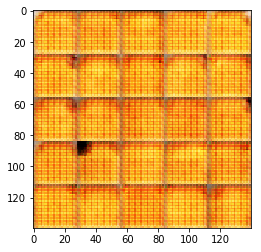

Epoch 1/1 Batch# 1310... Discriminator Loss: 0.9224... Generator Loss: 1.1627
Epoch 1/1 Batch# 1320... Discriminator Loss: 1.1859... Generator Loss: 2.2437
Epoch 1/1 Batch# 1330... Discriminator Loss: 0.7270... Generator Loss: 2.1000
Epoch 1/1 Batch# 1340... Discriminator Loss: 1.9928... Generator Loss: 2.7006
Epoch 1/1 Batch# 1350... Discriminator Loss: 0.9905... Generator Loss: 1.2216
Epoch 1/1 Batch# 1360... Discriminator Loss: 1.3647... Generator Loss: 2.2815
Epoch 1/1 Batch# 1370... Discriminator Loss: 1.1328... Generator Loss: 1.1432
Epoch 1/1 Batch# 1380... Discriminator Loss: 0.9939... Generator Loss: 1.0787
Epoch 1/1 Batch# 1390... Discriminator Loss: 1.0437... Generator Loss: 0.9430
Epoch 1/1 Batch# 1400... Discriminator Loss: 0.7646... Generator Loss: 4.0174


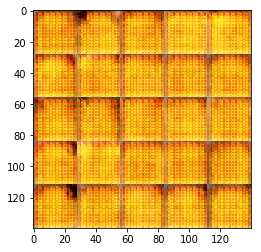

Epoch 1/1 Batch# 1410... Discriminator Loss: 0.5758... Generator Loss: 3.0181
Epoch 1/1 Batch# 1420... Discriminator Loss: 1.3123... Generator Loss: 2.0949
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.2657... Generator Loss: 0.7040
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.2744... Generator Loss: 1.0351
Epoch 1/1 Batch# 1450... Discriminator Loss: 1.5449... Generator Loss: 0.4695
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.2404... Generator Loss: 2.3618
Epoch 1/1 Batch# 1470... Discriminator Loss: 0.8756... Generator Loss: 1.8856
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.4301... Generator Loss: 0.5548
Epoch 1/1 Batch# 1490... Discriminator Loss: 1.0618... Generator Loss: 2.2561
Epoch 1/1 Batch# 1500... Discriminator Loss: 0.5594... Generator Loss: 3.2547


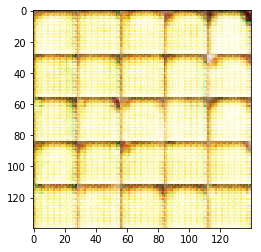

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.3180... Generator Loss: 1.1072
Epoch 1/1 Batch# 1520... Discriminator Loss: 1.3960... Generator Loss: 3.5247
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.0039... Generator Loss: 2.7943
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.4013... Generator Loss: 0.5451
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.0031... Generator Loss: 2.4725
Epoch 1/1 Batch# 1560... Discriminator Loss: 1.0739... Generator Loss: 1.2420
Epoch 1/1 Batch# 1570... Discriminator Loss: 1.7274... Generator Loss: 0.3724
Epoch 1/1 Batch# 1580... Discriminator Loss: 0.7140... Generator Loss: 2.5216
Epoch 1/1 Batch# 1590... Discriminator Loss: 1.6386... Generator Loss: 0.4104
Epoch 1/1 Batch# 1600... Discriminator Loss: 0.6806... Generator Loss: 2.1352


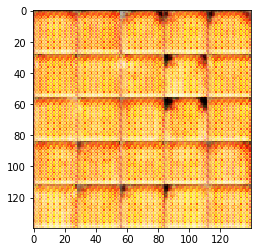

Epoch 1/1 Batch# 1610... Discriminator Loss: 1.8749... Generator Loss: 0.3013
Epoch 1/1 Batch# 1620... Discriminator Loss: 0.8118... Generator Loss: 2.0503
Epoch 1/1 Batch# 1630... Discriminator Loss: 1.2095... Generator Loss: 0.7138
Epoch 1/1 Batch# 1640... Discriminator Loss: 1.0452... Generator Loss: 1.1934
Epoch 1/1 Batch# 1650... Discriminator Loss: 2.1620... Generator Loss: 0.2294
Epoch 1/1 Batch# 1660... Discriminator Loss: 1.5757... Generator Loss: 1.5518
Epoch 1/1 Batch# 1670... Discriminator Loss: 0.8301... Generator Loss: 1.4830
Epoch 1/1 Batch# 1680... Discriminator Loss: 1.3740... Generator Loss: 0.7292
Epoch 1/1 Batch# 1690... Discriminator Loss: 0.9807... Generator Loss: 1.9678
Epoch 1/1 Batch# 1700... Discriminator Loss: 1.0223... Generator Loss: 1.1778


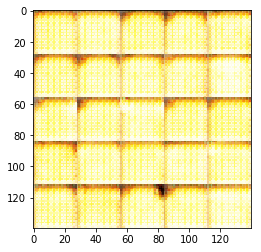

Epoch 1/1 Batch# 1710... Discriminator Loss: 1.3249... Generator Loss: 0.6264
Epoch 1/1 Batch# 1720... Discriminator Loss: 0.6551... Generator Loss: 3.6749
Epoch 1/1 Batch# 1730... Discriminator Loss: 0.8369... Generator Loss: 1.5913
Epoch 1/1 Batch# 1740... Discriminator Loss: 1.8203... Generator Loss: 3.8098
Epoch 1/1 Batch# 1750... Discriminator Loss: 1.0849... Generator Loss: 0.9479
Epoch 1/1 Batch# 1760... Discriminator Loss: 1.4776... Generator Loss: 0.6565
Epoch 1/1 Batch# 1770... Discriminator Loss: 1.0429... Generator Loss: 0.9672
Epoch 1/1 Batch# 1780... Discriminator Loss: 0.7596... Generator Loss: 1.5289
Epoch 1/1 Batch# 1790... Discriminator Loss: 2.5254... Generator Loss: 0.1507
Epoch 1/1 Batch# 1800... Discriminator Loss: 1.6220... Generator Loss: 0.6806


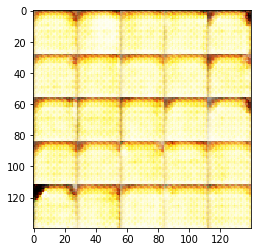

Epoch 1/1 Batch# 1810... Discriminator Loss: 0.9387... Generator Loss: 2.9370
Epoch 1/1 Batch# 1820... Discriminator Loss: 1.2198... Generator Loss: 0.7571
Epoch 1/1 Batch# 1830... Discriminator Loss: 0.9926... Generator Loss: 2.3797
Epoch 1/1 Batch# 1840... Discriminator Loss: 1.1074... Generator Loss: 1.4361
Epoch 1/1 Batch# 1850... Discriminator Loss: 0.8933... Generator Loss: 1.5947
Epoch 1/1 Batch# 1860... Discriminator Loss: 1.1882... Generator Loss: 0.7493
Epoch 1/1 Batch# 1870... Discriminator Loss: 0.9100... Generator Loss: 1.9939
Epoch 1/1 Batch# 1880... Discriminator Loss: 0.9858... Generator Loss: 1.3323
Epoch 1/1 Batch# 1890... Discriminator Loss: 1.3364... Generator Loss: 0.7387
Epoch 1/1 Batch# 1900... Discriminator Loss: 1.2841... Generator Loss: 0.8600


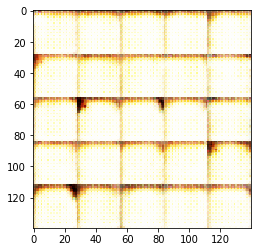

Epoch 1/1 Batch# 1910... Discriminator Loss: 0.7742... Generator Loss: 2.0584
Epoch 1/1 Batch# 1920... Discriminator Loss: 1.7357... Generator Loss: 0.4019
Epoch 1/1 Batch# 1930... Discriminator Loss: 0.8837... Generator Loss: 1.3495
Epoch 1/1 Batch# 1940... Discriminator Loss: 2.0601... Generator Loss: 0.2497
Epoch 1/1 Batch# 1950... Discriminator Loss: 1.1025... Generator Loss: 1.4434
Epoch 1/1 Batch# 1960... Discriminator Loss: 1.3702... Generator Loss: 0.7616
Epoch 1/1 Batch# 1970... Discriminator Loss: 1.2679... Generator Loss: 0.9034
Epoch 1/1 Batch# 1980... Discriminator Loss: 1.4304... Generator Loss: 0.5225
Epoch 1/1 Batch# 1990... Discriminator Loss: 0.9693... Generator Loss: 1.6018
Epoch 1/1 Batch# 2000... Discriminator Loss: 0.9564... Generator Loss: 1.1192


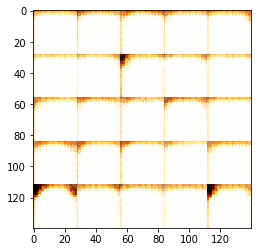

Epoch 1/1 Batch# 2010... Discriminator Loss: 0.7648... Generator Loss: 2.4674
Epoch 1/1 Batch# 2020... Discriminator Loss: 1.0894... Generator Loss: 1.1566
Epoch 1/1 Batch# 2030... Discriminator Loss: 1.1697... Generator Loss: 1.1019
Epoch 1/1 Batch# 2040... Discriminator Loss: 1.2410... Generator Loss: 2.5747
Epoch 1/1 Batch# 2050... Discriminator Loss: 0.6542... Generator Loss: 2.2161
Epoch 1/1 Batch# 2060... Discriminator Loss: 0.4984... Generator Loss: 5.1769
Epoch 1/1 Batch# 2070... Discriminator Loss: 0.6681... Generator Loss: 3.0250
Epoch 1/1 Batch# 2080... Discriminator Loss: 0.8492... Generator Loss: 1.8055
Epoch 1/1 Batch# 2090... Discriminator Loss: 0.9899... Generator Loss: 2.0732
Epoch 1/1 Batch# 2100... Discriminator Loss: 1.1665... Generator Loss: 1.1263


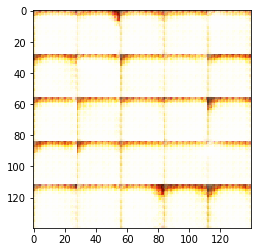

Epoch 1/1 Batch# 2110... Discriminator Loss: 1.5170... Generator Loss: 0.4761
Epoch 1/1 Batch# 2120... Discriminator Loss: 0.9989... Generator Loss: 1.0150
Epoch 1/1 Batch# 2130... Discriminator Loss: 1.0053... Generator Loss: 1.8081
Epoch 1/1 Batch# 2140... Discriminator Loss: 0.6898... Generator Loss: 1.8675
Epoch 1/1 Batch# 2150... Discriminator Loss: 1.1101... Generator Loss: 1.0357
Epoch 1/1 Batch# 2160... Discriminator Loss: 1.4731... Generator Loss: 0.5802
Epoch 1/1 Batch# 2170... Discriminator Loss: 0.8209... Generator Loss: 1.7217
Epoch 1/1 Batch# 2180... Discriminator Loss: 1.6697... Generator Loss: 0.4133
Epoch 1/1 Batch# 2190... Discriminator Loss: 1.6864... Generator Loss: 0.3781
Epoch 1/1 Batch# 2200... Discriminator Loss: 1.0994... Generator Loss: 1.3622


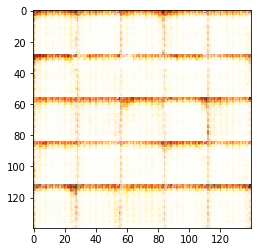

Epoch 1/1 Batch# 2210... Discriminator Loss: 0.8813... Generator Loss: 2.0619
Epoch 1/1 Batch# 2220... Discriminator Loss: 1.7780... Generator Loss: 0.3424
Epoch 1/1 Batch# 2230... Discriminator Loss: 0.9257... Generator Loss: 1.5564
Epoch 1/1 Batch# 2240... Discriminator Loss: 0.8300... Generator Loss: 1.6142
Epoch 1/1 Batch# 2250... Discriminator Loss: 0.9383... Generator Loss: 2.0570
Epoch 1/1 Batch# 2260... Discriminator Loss: 1.4930... Generator Loss: 0.6654
Epoch 1/1 Batch# 2270... Discriminator Loss: 1.1133... Generator Loss: 1.3633
Epoch 1/1 Batch# 2280... Discriminator Loss: 1.8503... Generator Loss: 0.3074
Epoch 1/1 Batch# 2290... Discriminator Loss: 1.4652... Generator Loss: 1.0559
Epoch 1/1 Batch# 2300... Discriminator Loss: 0.8699... Generator Loss: 2.0879


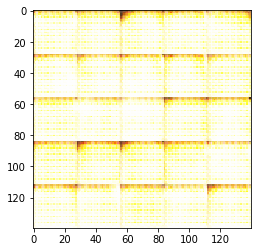

Epoch 1/1 Batch# 2310... Discriminator Loss: 0.9946... Generator Loss: 2.9284
Epoch 1/1 Batch# 2320... Discriminator Loss: 0.9069... Generator Loss: 1.2927
Epoch 1/1 Batch# 2330... Discriminator Loss: 0.7582... Generator Loss: 1.5954
Epoch 1/1 Batch# 2340... Discriminator Loss: 0.9473... Generator Loss: 2.0540
Epoch 1/1 Batch# 2350... Discriminator Loss: 1.2018... Generator Loss: 1.0304
Epoch 1/1 Batch# 2360... Discriminator Loss: 1.8030... Generator Loss: 0.3551
Epoch 1/1 Batch# 2370... Discriminator Loss: 1.2668... Generator Loss: 0.8013
Epoch 1/1 Batch# 2380... Discriminator Loss: 1.0717... Generator Loss: 1.8883
Epoch 1/1 Batch# 2390... Discriminator Loss: 1.7767... Generator Loss: 0.3439
Epoch 1/1 Batch# 2400... Discriminator Loss: 1.2327... Generator Loss: 0.7136


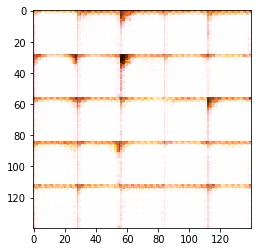

Epoch 1/1 Batch# 2410... Discriminator Loss: 1.8257... Generator Loss: 0.3475
Epoch 1/1 Batch# 2420... Discriminator Loss: 0.9402... Generator Loss: 1.5927
Epoch 1/1 Batch# 2430... Discriminator Loss: 0.9483... Generator Loss: 1.2150
Epoch 1/1 Batch# 2440... Discriminator Loss: 1.3960... Generator Loss: 3.2094
Epoch 1/1 Batch# 2450... Discriminator Loss: 1.7091... Generator Loss: 0.3672
Epoch 1/1 Batch# 2460... Discriminator Loss: 1.4362... Generator Loss: 0.6317
Epoch 1/1 Batch# 2470... Discriminator Loss: 1.2064... Generator Loss: 1.1952
Epoch 1/1 Batch# 2480... Discriminator Loss: 1.6919... Generator Loss: 0.4101
Epoch 1/1 Batch# 2490... Discriminator Loss: 1.3706... Generator Loss: 0.5948
Epoch 1/1 Batch# 2500... Discriminator Loss: 0.9903... Generator Loss: 2.5845


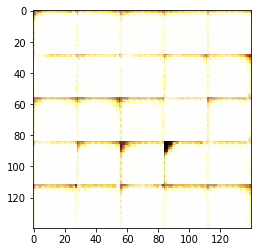

Epoch 1/1 Batch# 2510... Discriminator Loss: 0.9335... Generator Loss: 1.7436
Epoch 1/1 Batch# 2520... Discriminator Loss: 1.9113... Generator Loss: 0.3329
Epoch 1/1 Batch# 2530... Discriminator Loss: 1.3124... Generator Loss: 0.8016
Epoch 1/1 Batch# 2540... Discriminator Loss: 1.4540... Generator Loss: 2.3134
Epoch 1/1 Batch# 2550... Discriminator Loss: 1.3777... Generator Loss: 0.7233
Epoch 1/1 Batch# 2560... Discriminator Loss: 0.8956... Generator Loss: 1.4224
Epoch 1/1 Batch# 2570... Discriminator Loss: 1.5158... Generator Loss: 0.7739
Epoch 1/1 Batch# 2580... Discriminator Loss: 1.4415... Generator Loss: 0.6566
Epoch 1/1 Batch# 2590... Discriminator Loss: 0.8614... Generator Loss: 1.8905
Epoch 1/1 Batch# 2600... Discriminator Loss: 2.2933... Generator Loss: 0.1949


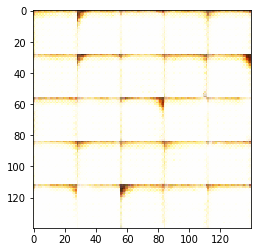

Epoch 1/1 Batch# 2610... Discriminator Loss: 1.2472... Generator Loss: 2.1579
Epoch 1/1 Batch# 2620... Discriminator Loss: 2.0625... Generator Loss: 0.2506
Epoch 1/1 Batch# 2630... Discriminator Loss: 1.3040... Generator Loss: 0.7469
Epoch 1/1 Batch# 2640... Discriminator Loss: 1.1775... Generator Loss: 1.0015
Epoch 1/1 Batch# 2650... Discriminator Loss: 1.9413... Generator Loss: 0.3097
Epoch 1/1 Batch# 2660... Discriminator Loss: 1.4915... Generator Loss: 0.5331
Epoch 1/1 Batch# 2670... Discriminator Loss: 1.1115... Generator Loss: 1.4945
Epoch 1/1 Batch# 2680... Discriminator Loss: 1.2028... Generator Loss: 0.8343
Epoch 1/1 Batch# 2690... Discriminator Loss: 1.1215... Generator Loss: 0.9050
Epoch 1/1 Batch# 2700... Discriminator Loss: 2.6053... Generator Loss: 0.1425


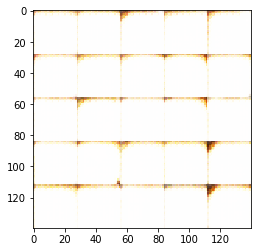

Epoch 1/1 Batch# 2710... Discriminator Loss: 1.1520... Generator Loss: 0.8262
Epoch 1/1 Batch# 2720... Discriminator Loss: 1.5789... Generator Loss: 0.4608
Epoch 1/1 Batch# 2730... Discriminator Loss: 1.0393... Generator Loss: 1.0623
Epoch 1/1 Batch# 2740... Discriminator Loss: 1.6670... Generator Loss: 0.6359
Epoch 1/1 Batch# 2750... Discriminator Loss: 1.5030... Generator Loss: 1.0418
Epoch 1/1 Batch# 2760... Discriminator Loss: 1.4980... Generator Loss: 0.5279
Epoch 1/1 Batch# 2770... Discriminator Loss: 1.2589... Generator Loss: 0.8043
Epoch 1/1 Batch# 2780... Discriminator Loss: 1.5184... Generator Loss: 0.4881
Epoch 1/1 Batch# 2790... Discriminator Loss: 0.9625... Generator Loss: 1.6952
Epoch 1/1 Batch# 2800... Discriminator Loss: 1.9932... Generator Loss: 0.2641


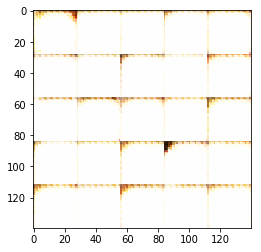

Epoch 1/1 Batch# 2810... Discriminator Loss: 0.7668... Generator Loss: 1.5294
Epoch 1/1 Batch# 2820... Discriminator Loss: 0.9372... Generator Loss: 1.1886
Epoch 1/1 Batch# 2830... Discriminator Loss: 0.8471... Generator Loss: 2.7529
Epoch 1/1 Batch# 2840... Discriminator Loss: 2.2555... Generator Loss: 1.2600
Epoch 1/1 Batch# 2850... Discriminator Loss: 1.7409... Generator Loss: 0.4092
Epoch 1/1 Batch# 2860... Discriminator Loss: 0.7776... Generator Loss: 2.4264
Epoch 1/1 Batch# 2870... Discriminator Loss: 1.1996... Generator Loss: 0.9833
Epoch 1/1 Batch# 2880... Discriminator Loss: 1.2869... Generator Loss: 0.7758
Epoch 1/1 Batch# 2890... Discriminator Loss: 1.1908... Generator Loss: 1.6921
Epoch 1/1 Batch# 2900... Discriminator Loss: 1.0308... Generator Loss: 1.1732


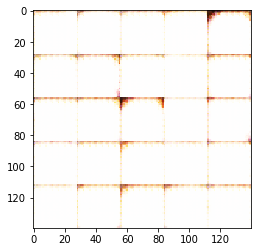

Epoch 1/1 Batch# 2910... Discriminator Loss: 0.7337... Generator Loss: 2.6287
Epoch 1/1 Batch# 2920... Discriminator Loss: 0.9733... Generator Loss: 2.6796
Epoch 1/1 Batch# 2930... Discriminator Loss: 1.4841... Generator Loss: 0.4870
Epoch 1/1 Batch# 2940... Discriminator Loss: 1.4606... Generator Loss: 1.7434
Epoch 1/1 Batch# 2950... Discriminator Loss: 1.0042... Generator Loss: 2.5136
Epoch 1/1 Batch# 2960... Discriminator Loss: 0.8490... Generator Loss: 2.2163
Epoch 1/1 Batch# 2970... Discriminator Loss: 1.2211... Generator Loss: 2.0065
Epoch 1/1 Batch# 2980... Discriminator Loss: 1.2308... Generator Loss: 0.6923
Epoch 1/1 Batch# 2990... Discriminator Loss: 1.4483... Generator Loss: 0.5333
Epoch 1/1 Batch# 3000... Discriminator Loss: 0.7963... Generator Loss: 1.8959


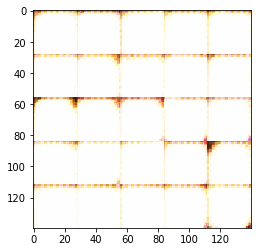

Epoch 1/1 Batch# 3010... Discriminator Loss: 0.9797... Generator Loss: 1.0023
Epoch 1/1 Batch# 3020... Discriminator Loss: 1.5639... Generator Loss: 0.5404
Epoch 1/1 Batch# 3030... Discriminator Loss: 1.7853... Generator Loss: 0.3571
Epoch 1/1 Batch# 3040... Discriminator Loss: 2.1404... Generator Loss: 2.2901
Epoch 1/1 Batch# 3050... Discriminator Loss: 1.1792... Generator Loss: 1.1234
Epoch 1/1 Batch# 3060... Discriminator Loss: 1.2499... Generator Loss: 0.7149
Epoch 1/1 Batch# 3070... Discriminator Loss: 1.3634... Generator Loss: 0.6029
Epoch 1/1 Batch# 3080... Discriminator Loss: 1.2431... Generator Loss: 1.1244
Epoch 1/1 Batch# 3090... Discriminator Loss: 0.6815... Generator Loss: 3.4952
Epoch 1/1 Batch# 3100... Discriminator Loss: 1.4482... Generator Loss: 1.8950


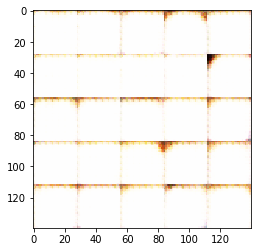

Epoch 1/1 Batch# 3110... Discriminator Loss: 1.3319... Generator Loss: 0.5851
Epoch 1/1 Batch# 3120... Discriminator Loss: 1.5949... Generator Loss: 0.5354
Epoch 1/1 Batch# 3130... Discriminator Loss: 1.3703... Generator Loss: 0.5889
Epoch 1/1 Batch# 3140... Discriminator Loss: 1.2620... Generator Loss: 0.7082
Epoch 1/1 Batch# 3150... Discriminator Loss: 1.0246... Generator Loss: 3.3440
Epoch 1/1 Batch# 3160... Discriminator Loss: 1.2054... Generator Loss: 2.2583


In [64]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.